In [1]:
import pandas as pd
import numpy as np

In [2]:
#Load ML Packages
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
#Others
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

In [3]:
df=pd.read_excel('Data-reduced.xlsx')
df.head(10)

,Check FC,DESCRIPTION,Herstellung
0,NaN,.Smoothfood Brot 48x70g,"Brot, übrige"
1,1,"""Apfel Boskoop ""Thurgauer""",Äpfel CH
2,1,"""Aprikosen ""ROUGECOT""",Aprikosen
3,1,"""Aprikosen ""VANILLACOT""",Aprikosen
4,1,"""Aprikosen AAA ""Walliser""",Aprikosen
5,NaN,"""Artischocken 13er ""CASTEL""","Gemüse, KA"
6,NaN,"""Artischocken CASTEL ""Bretagne""","Gemüse, KA"
7,NaN,"""Basilikum süss """"Horapah"""", 100 g""","Kräuter, diverse"
8,1,"""Birnen Celina ""Thurgauer""",Birnen CH
9,1,"""Birnen Conference ""Thurgauer""",Birnen CH


In [4]:
df = df[(df['Check FC'] == 1) | (df['Check FC'].isna())]
df=df[['DESCRIPTION','Herstellung']]
df.head()


,DESCRIPTION,Herstellung
0,.Smoothfood Brot 48x70g,"Brot, übrige"
1,"""Apfel Boskoop ""Thurgauer""",Äpfel CH
2,"""Aprikosen ""ROUGECOT""",Aprikosen
3,"""Aprikosen ""VANILLACOT""",Aprikosen
4,"""Aprikosen AAA ""Walliser""",Aprikosen


In [5]:
df.describe()

,DESCRIPTION,Herstellung
count,41817,41817
unique,41817,358
top,.Smoothfood Brot 48x70g,NONFOOD
freq,1,1937


In [7]:
value_counts=df.Herstellung.value_counts()
to_keep = value_counts[value_counts >=5].index
df = df[df['Herstellung'].isin(to_keep)]

In [8]:
# Filter the DataFrame to separate rows with the specific label and other rows
df_label = df[df['Herstellung'] == 'NONFOOD']
df_other = df[df['Herstellung'] != 'NONFOOD']

# Randomly sample the specified number of elements from the label's DataFrame
sampled_df_label = df_label.sample(n=1500, random_state=42)

# Combine the sampled elements with the rest of the DataFrame
df_balanced = pd.concat([sampled_df_label, df_other])

# Optional: Shuffle the final DataFrame
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Download the stopwords if you haven't done so
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

# Get the German stop words
stop_words = stopwords.words('german')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [12]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def clean_text(text):
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenization
    tokens = word_tokenize(text)
    # Removing stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # Removing numbers
    #tokens = [word for word in tokens if not word.isdigit()]
    # Removing extra whitespaces
    text = ' '.join(tokens)
    return text
df['DESCRIPTION']= df['DESCRIPTION'].apply(clean_text)
#df['Herstellung']=df['Herstellung'].apply(clean_text)
df['Herstellung']=df['Herstellung'].str.strip().str.lower()

In [13]:
df.head()

,DESCRIPTION,Herstellung
0,poulet nugget paniert fritiert tk ca 18 kg,"poulet, kat. 1, paniert, ch"
1,wachtel eier freiämter 8er schale,eier
2,lunkow glasnudeln 100 g,glutenfreie teigwaren
3,frisco imperi sorbet himbeer 38 l,sorbet
4,wiberg zimt ganz 420g,"kräuter, diverse"


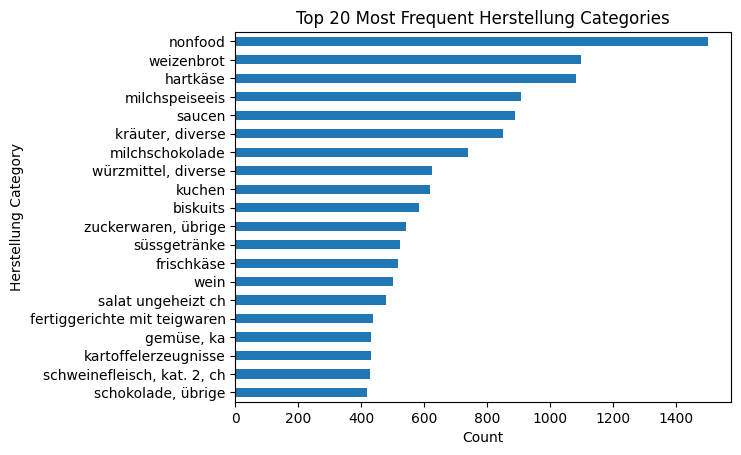

In [14]:
# @title Top 20 Most Frequent Herstellung Categories

import matplotlib.pyplot as plt
import pandas as pd

df['Herstellung'].value_counts().head(20).sort_values().plot(kind='barh')
plt.title('Top 20 Most Frequent Herstellung Categories')
plt.xlabel('Count')
_ = plt.ylabel('Herstellung Category')

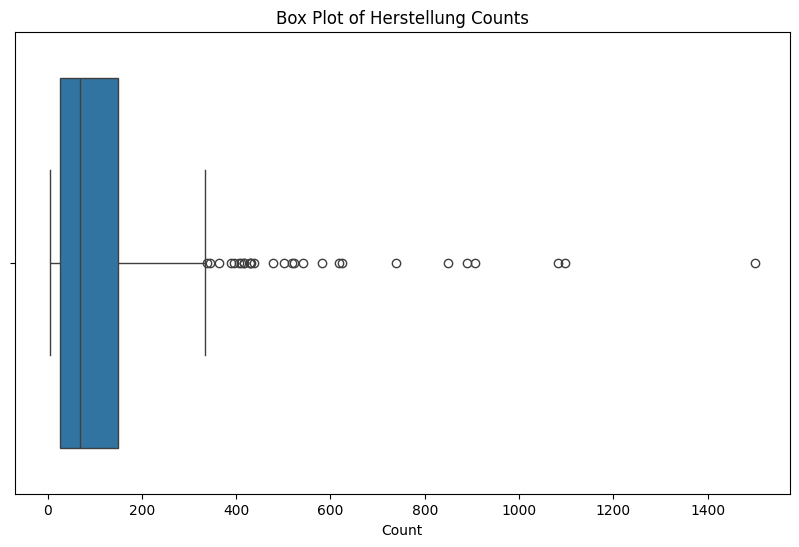

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a box plot for the counts of the 'Herstellung' column
plt.figure(figsize=(10, 6))  # Adjust the figure size if necessary
sns.boxplot(x=df['Herstellung'].value_counts())

# Add title and labels
plt.title('Box Plot of Herstellung Counts')
plt.xlabel('Count')

# Show the plot
plt.show()

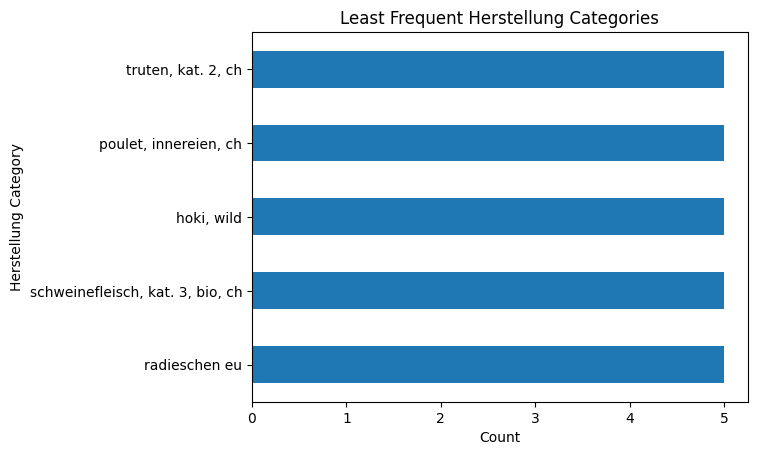

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

df['Herstellung'].value_counts().tail().sort_values().plot(kind='barh')
plt.title('Least Frequent Herstellung Categories')
plt.xlabel('Count')
_ = plt.ylabel('Herstellung Category')

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN
from tensorflow.keras.models import Sequential

In [18]:
# Hyperparameters
max_words = 20000 # max number of words to use in the vocabulary
max_len = 10 # max length of each text (in terms of number of words)
embedding_dim = 50 # dimension of word embeddings
#lstm_units = 64 # number of units in the LSTM layer
#num_classes = len(set(labels)) # number of classes

In [19]:
# Tokenize the texts and create a vocabulary
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.DESCRIPTION.values)
X = tokenizer.texts_to_sequences(df.DESCRIPTION.values)

In [20]:
# Pad the sequences so they all have the same length
X = pad_sequences(X, maxlen=max_len)

In [21]:
Y=pd.get_dummies(df.Herstellung).values

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, stratify=Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(33036, 10) (33036, 314)
(8259, 10) (8259, 314)


In [23]:
labels= df.Herstellung.unique()

In [ ]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE()
# X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

In [24]:
import os
import random
# Set random seeds for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [51]:
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization
from tensorflow.keras.regularizers import l2
# Build the model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100))
model.add(Dense(314, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])


In [52]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [53]:

from sklearn.utils.class_weight import compute_class_weight

Y_train_labels = np.argmax(Y_train, axis=1)

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(Y_train_labels),
                                     y=Y_train_labels)

# Create a dictionary for Keras
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}


In [33]:
# from sklearn.utils.class_weight import compute_sample_weight

# # Assume Y_train contains the labels for each sample in the training set
# sample_weights = compute_sample_weight(class_weight='balanced', y=Y_train)

In [54]:
from tensorflow.keras.callbacks import EarlyStopping
epochs = 20
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, class_weight=class_weights_dict, validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/20
930/930 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.0354 - loss: 5.6560 - val_accuracy: 0.2258 - val_loss: 3.7430
Epoch 2/20
930/930 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.2889 - loss: 3.9691 - val_accuracy: 0.4649 - val_loss: 2.5639
Epoch 3/20
930/930 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.5246 - loss: 2.5583 - val_accuracy: 0.5823 - val_loss: 2.0363
Epoch 4/20
930/930 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.6606 - loss: 1.7151 - val_accuracy: 0.6353 - val_loss: 1.7696
Epoch 5/20
930/930 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.7354 - loss: 1.2172 - val_accuracy: 0.6683 - val_loss: 1.6523
Epoch 6/20
930/930 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.7904 - loss: 0.9010 - val_accuracy: 0.6807 - val_loss: 1.6179
Epoch 7/20
930/930 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8228 - loss: 0.6871 - val_accuracy: 0.6955 - val_loss: 1.6069
Epoch 8/20
930/930 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8437 - loss: 0.5486 - 

In [55]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7159 - loss: 1.6074
Test set
  Loss: 1.593
  Accuracy: 0.720


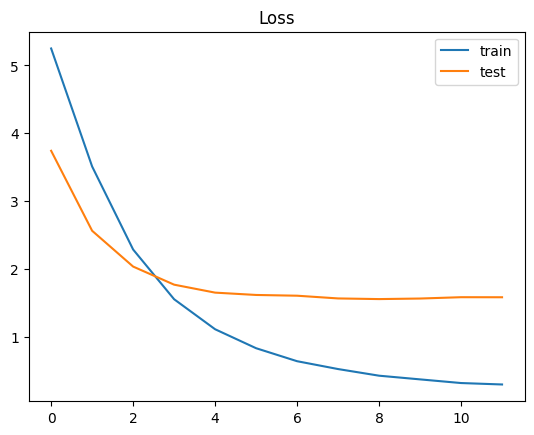

In [56]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

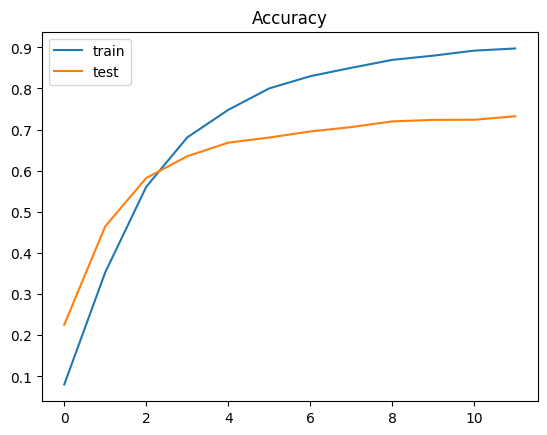

In [57]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [38]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
y_pred_prob = model.predict(X_test)  # Outputs probabilities

# Convert probabilities to class labels
# Use argmax if it's a multiclass problem with probabilities per class
y_pred = np.argmax(y_pred_prob, axis=1)

# If Y_test is multilabel-indicator, convert y_pred to multilabel-indicator:
from sklearn.preprocessing import MultiLabelBinarizer

# Get all unique labels from Y_test
all_labels = np.arange(Y_test.shape[1]) # Assumes labels are represented by columns

mlb = MultiLabelBinarizer(classes=all_labels)
y_pred_multilabel = mlb.fit_transform(y_pred.reshape(-1, 1))

# Generate the classification report using the appropriate format:
# If Y_test is multilabel-indicator
print(classification_report(Y_test, y_pred_multilabel,target_names=labels))

259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
                                    precision    recall  f1-score   support

       poulet, kat. 1, paniert, ch       0.50      0.60      0.55        10
                              eier       0.70      0.95      0.81        20
             glutenfreie teigwaren       0.58      0.73      0.65        15
                            sorbet       0.75      0.82      0.78        11
                  kräuter, diverse       1.00      0.75      0.86         4
             zwiebeln ungeheizt ch       1.00      1.00      1.00         4
                        weizenbrot       0.78      0.90      0.84        20
           kalbfleisch, kat. 2, ch       0.58      0.64      0.61        11
        rindfleisch, innereien, ch       0.67      0.60      0.63        10
                    shrimps, zucht       1.00      0.89      0.94         9
           kalbfleisch, kat. 3, ch       0.25      0.67      0.36         3
                          äpfel ch       0.24 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#GRU

In [41]:
from tensorflow.keras.layers import GRU

# GRU Model
gru_model = Sequential([
    Embedding(input_dim=20000, output_dim=50, input_length=20),
    GRU(100),
    Dense(64, activation='relu'),
    Dense(314, activation='softmax')  # Adjust the output units for your number of classes
])

gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gru_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Training the model
history_gru=gru_model.fit(X_train, Y_train, epochs=10,class_weight=class_weights_dict, batch_size=128, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.0125 - loss: 5.7559 - val_accuracy: 0.0443 - val_loss: 5.0429
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.0710 - loss: 5.0599 - val_accuracy: 0.1503 - val_loss: 3.9354
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.2312 - loss: 3.8358 - val_accuracy: 0.3172 - val_loss: 3.1138
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4230 - loss: 2.6349 - val_accuracy: 0.4377 - val_loss: 2.7146
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.5731 - loss: 1.8077 - val_accuracy: 0.5166 - val_loss: 2.6551
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.6926 - loss: 1.2203 - val_accuracy: 0.5480 - val_loss: 2.5816
Epoch 7/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.7635 - loss: 0.9117 - val_accuracy: 0.5953 - val_loss: 2.5832
Epoch 8/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.8077 - loss: 0.6982 - val_

In [43]:
accr = gru_model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6295 - loss: 2.4973
Test set
  Loss: 2.555
  Accuracy: 0.623


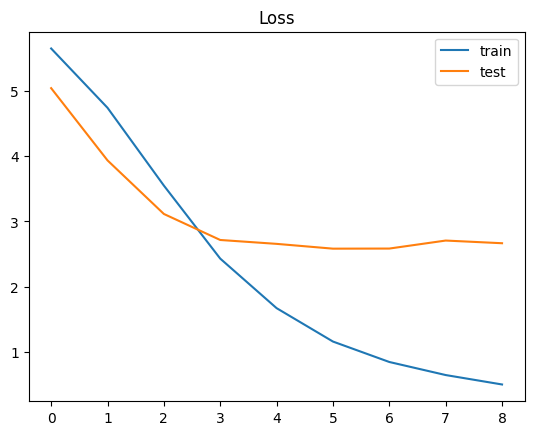

In [44]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history_gru.history['loss'], label='train')
plt.plot(history_gru.history['val_loss'], label='test')
plt.legend()
plt.show();

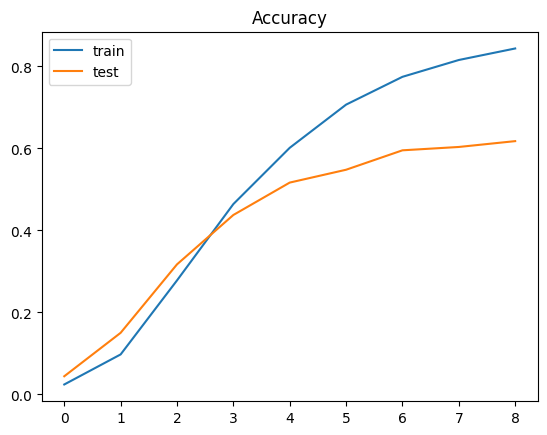

In [45]:
plt.title('Accuracy')
plt.plot(history_gru.history['accuracy'], label='train')
plt.plot(history_gru.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [46]:
# import sklearn.metrics as metrics
# from sklearn.metrics import classification_report
# y_pred_prob = gru_model.predict(X_test)  # Outputs probabilities

# # Convert probabilities to class labels
# # Use argmax if it's a multiclass problem with probabilities per class
# y_pred = np.argmax(y_pred_prob, axis=1)

# # If Y_test is multilabel-indicator, convert y_pred to multilabel-indicator:
# from sklearn.preprocessing import MultiLabelBinarizer

# # Get all unique labels from Y_test
# all_labels = np.arange(Y_test.shape[1]) # Assumes labels are represented by columns

# mlb = MultiLabelBinarizer(classes=all_labels)
# y_pred_multilabel = mlb.fit_transform(y_pred.reshape(-1, 1))

# # Generate the classification report using the appropriate format:
# # If Y_test is multilabel-indicator
# print(classification_report(Y_test, y_pred_multilabel,target_names=labels))

#RNN

In [47]:
# RNN Model
from tensorflow.keras.layers import SimpleRNN
rnn_model = Sequential([
    Embedding(input_dim=20000, output_dim=50, input_length=20),
    SimpleRNN(100),
    Dense(64, activation='relu'),
    Dense(314, activation='softmax')  # Adjust the output units for your number of classes
])

rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Training the model
history_rnn=rnn_model.fit(X_train, Y_train, epochs=10,class_weight=class_weights_dict, batch_size=128, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.0168 - loss: 5.7566 - val_accuracy: 0.0678 - val_loss: 5.2988
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.1029 - loss: 5.1665 - val_accuracy: 0.2023 - val_loss: 3.8768
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.2995 - loss: 3.7370 - val_accuracy: 0.3597 - val_loss: 3.0576
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.4872 - loss: 2.4380 - val_accuracy: 0.4166 - val_loss: 2.8287
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6278 - loss: 1.5902 - val_accuracy: 0.4794 - val_loss: 2.5692
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7369 - loss: 1.0237 - val_accuracy: 0.5056 - val_loss: 2.5361
Epoch 7/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7979 - loss: 0.7188 - val_accuracy: 0.5437 - val_loss: 2.4524
Epoch 8/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8553 - loss: 0.4773 - val_acc

In [49]:
incraccr = rnn_model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5790 - loss: 2.5401
Test set
  Loss: 2.555
  Accuracy: 0.623
